# Reading and cleaning of the data

In [1]:
import pandas as pd
import numpy as np
from importlib import import_module, reload
import functions as f
import matplotlib.pyplot as plt

In [2]:
doc_name_dct = {"NUMERO_UAI_Courant": "Numéro de l'établissement", 
                       "Année d’obtention": "Annee", 
                       "Situation": "situation",
                       "Part de femmes diplômées":"% femmes",
                       "Nombre de répondant":"Nombre de réponses",
                       "Part de docteurs déclarant avoir été financés pour réaliser leur thèse":"% de diplômés boursiers",
                       "Taux d’emploi stable":"% emplois stables",
                       "Taux d’emploi cadre":"% emplois cadre",
                       "Taux d’emploi à temps plein":"% emplois à temps plein",
                       "Salaire net mensuel médian des emplois à temps plein":"Salaire net médian des emplois à temps plein",
                       "Salaire brut annuel moyen estimé":"Salaire brut annuel estimé",
                       "Taux d'insertion":"Taux d’insertion",
                       "Discipline principale agrégée de l’école doctorale":"Domaine"
                      }

df_doc, df_mas, df_lp, univ_names = f.load_data()
df_doc = f.rename_cols(doc_name_dct, df_doc)
df_all = f.concat_dfs([df_lp, df_mas, df_doc])

In [3]:
# Keeping only informative for this project columns
cols_to_keep = [0, 1, 2, 5, 7, 9, 10, 11, 12, 13, 15, 18, 19, 20, 23, 26]
df_all = f.df_clean(df_all, cols_to_keep)

In [4]:
# Adding university names
df_all = f.merge_uni_all(univ_names, df_all)

## Plotting function

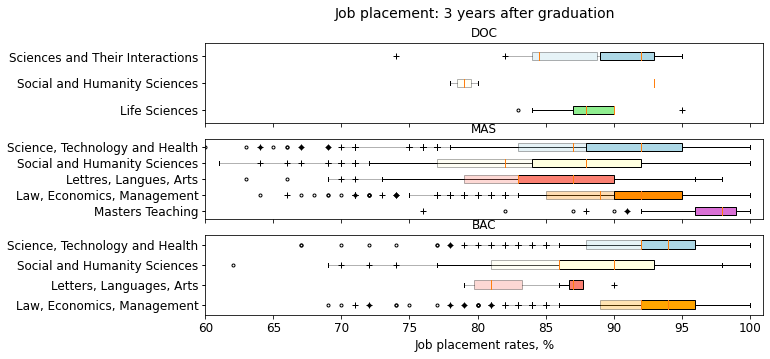

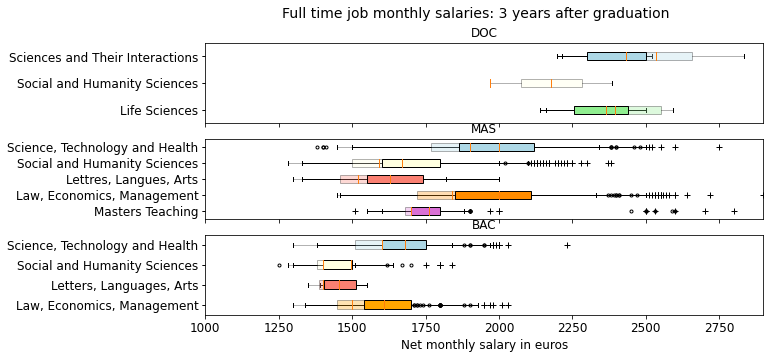

In [5]:
f.plot_domain_wise(df_all, "job placement", "job_placement.png")
f.plot_domain_wise(df_all, "salary", "salary.png")

In [6]:
print(f'Total number of answers from students: {df_all["Nombre de réponses"].dropna().sum()}')

Total number of answers from students: 1933064.0


In [7]:
print(f'Number of universities: {df_all["Libellé"].unique}')

Number of universities: <bound method Series.unique of 0                            NaN
1                            NaN
2                            NaN
3                            NaN
4                            NaN
                  ...           
16209        Sorbonne Université
16210    Université de Bourgogne
16211     Université de Bordeaux
16212    Université Paris-Saclay
16213    Université Paris-Saclay
Name: Libellé, Length: 16214, dtype: object>


In [8]:
df_all["Libellé"].value_counts().count()

61

# Best universities

In [9]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16214 entries, 0 to 16213
Data columns (total 23 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Annee                                         16214 non-null  int64  
 1   Diplôme                                       16214 non-null  object 
 2   Numéro de l'établissement                     16214 non-null  object 
 3   Académie                                      15827 non-null  object 
 4   Domaine                                       16214 non-null  object 
 5   Discipline                                    16180 non-null  object 
 6   situation                                     16214 non-null  object 
 7   Remarque                                      0 non-null      object 
 8   Nombre de réponses                            16207 non-null  float64
 9   Taux de réponse                               16069 non-null 

In [10]:
f.univ_ranking(df_all)

In [11]:
df_all['rank'].head(10)

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    4.0
7    4.0
8    4.0
9    NaN
Name: rank, dtype: float64

## Map tricks

In [12]:
import folium
from folium import plugins
import matplotlib as plt

In [13]:
m = folium.Map(location=[47.0000, 2.0000], zoom_start=5.0, width=400, height=400)

In [14]:
m = f.univ_locations(df_all)

In [15]:
m

In [16]:
# def students_num(df, time_per=1):
#     cond_1 = cond_sit(df, time_per, 0) 
#     cond_2 = cond_sit(df, time_per, 1) 
#     cond =  cond_1 | cond_2

#     cols_to_keep = [22,19,8, 16, 0, 10, 12]

#     df_map = f.keep_columns(df, cols_to_keep)
#     df_map = df_map.loc[cond].dropna()

#     cols_gr = ["Géolocalisation","Libellé","Diploma Domain", "Annee"]
    
#     df_map_ = pd.DataFrame(df_map.groupby(by=cols_gr)['Nombre de réponses'].sum())
#     df_map_['mean salary'] = df_map.groupby(by=cols_gr)[col_name_by_key("salary")]\
#                             .mean()
#     df_map_["avg job placement rate"] = df_map.groupby(by=cols_gr)\
#                                         [col_name_by_key("job placement")].mean()
#     df_map_.reset_index(inplace=True)
#     return df_map_

df_st_num = f.students_num(df_all, time_per=1)

In [17]:
print(f.d_domains()[3:8])
for i in range(2012, 2017):
    print(f'{i} : {df_st_num[df_st_num["Annee"] == i]["Nombre de réponses"].sum()}')
    print(len(df_st_num[df_st_num["Annee"] == i]))
f.domain_colors()[1]

['MASTER ENS Masters enseignement', 'MASTER LMD Droit, économie et gestion', 'MASTER LMD Lettres, langues, arts', 'MASTER LMD Sciences humaines et sociales', 'MASTER LMD Sciences, technologies et santé']
2012 : 34795.0
147
2013 : 50550.0
209
2014 : 57978.0
233
2015 : 64183.0
240
2016 : 62546.0
239


['orchid', 'darkorange', 'salmon', 'lightyellow', 'lightblue']

In [18]:
df_st_num

,Géolocalisation,Libellé,Diploma Domain,Annee,Nombre de réponses,mean salary,avg job placement rate
0,"-20.9019,55.4843",Université de La Réunion,MASTER ENS Masters enseignement,2012,83.0,2530.0,93.0
1,"-20.9019,55.4843",Université de La Réunion,MASTER ENS Masters enseignement,2013,77.0,2500.0,95.0
2,"-20.9019,55.4843",Université de La Réunion,MASTER ENS Masters enseignement,2014,109.0,2590.0,93.0
3,"-20.9019,55.4843",Université de La Réunion,MASTER ENS Masters enseignement,2015,73.0,2600.0,90.0
4,"-20.9019,55.4843",Université de La Réunion,MASTER ENS Masters enseignement,2016,93.0,2500.0,94.0
...,...,...,...,...,...,...,...
1063,"51.0391,2.37216",Université du Littoral Côte d'Opale,"MASTER LMD Sciences, technologies et santé",2012,139.0,1650.0,87.0
1064,"51.0391,2.37216",Université du Littoral Côte d'Opale,"MASTER LMD Sciences, technologies et santé",2013,66.0,1850.0,81.0
1065,"51.0391,2.37216",Université du Littoral Côte d'Opale,"MASTER LMD Sciences, technologies et santé",2014,74.0,1780.0,86.0
1066,"51.0391,2.37216",Université du Littoral Côte d'Opale,"MASTER LMD Sciences, technologies et santé",2015,147.0,1735.0,86.0


In [19]:
m = f.students_jbplcmt_fig(df_st_num)
m

In [20]:
m = folium.Map(location=[47.0000, 2.0000], zoom_start=5.0, width=500, height=500)

In [21]:
m = f.students_distr_fig(df_st_num, year=2016)
m

## Hypothesis testing

### Workflow
- prepare data subsets
- check for normality p_n = 0.05
- hypothesis testing: significant difference between samples


### First hypothesis: Higher level of education give better chances to get (permanent) job

In [22]:
f.calc_n_st(df_all)
cols_to_keep = [0,1,4,6, 8,9,10, 11, 16, 17, 23, 24, 25]
df_hyp1 = f.keep_columns(df_all, cols_to_keep)

In [23]:
# dds = [f.d_domains()[-1], f.d_domains()[7], f.d_domains()[2]]
dds = [f.d_domains()[-1], f.d_domains()[7]]
h1 = f.weighted_dfs(dds,df_hyp1, time_per=3)

In [24]:
### Job placement bac vs mas:

In [25]:
from scipy import stats

# Any job placement    
f.p_val(h1[0], h1[1], col_name="weighted job placement")
f.p_val(h1[0], h1[1], col_name="Taux d’insertion")
# Full-time job placement
f.p_val(h1[0], h1[1], col_name="weighted ft job placement")
f.p_val(h1[0], h1[1], col_name="taux temp plein - out of number of answers")

We reject the null hypothesis. Our datasets are statistically different
Means for column weighted job placement:
1: 0.0017000983908337822
2: 0.0007665926793763343
p-value: 1.7612404412033714e-05
We reject the null hypothesis. Our datasets are statistically different
Means for column Taux d’insertion:
1: 93.85220729366603
2: 91.06445837063563
p-value: 8.793186851147393e-25
We reject the null hypothesis. Our datasets are statistically different
Means for column weighted ft job placement:
1: 0.0017436598777311933
2: 0.0007924678555576962
p-value: 2.6155289959687123e-05
We reject the null hypothesis. Our datasets are statistically different
Means for column taux temp plein - out of number of answers:
1: 92.1743232323233
2: 88.55695062923529
p-value: 6.962056511114023e-28


6.962056511114023e-28

### Second hypothesis: Higher ranked schools give same job placement as the rest of schools.

In [26]:
cols_to_keep = [0,1,4,6, 8,9,10, 11,16, 22, 23, 24, 25]
df_hyp2 = f.keep_columns(df_all, cols_to_keep)

In [27]:
h2 = f.ranked_dfs(dds, df_hyp2, time_per=3)

In [28]:
from scipy import stats
ranks = ['h', 'l']
for i, dd in enumerate(dds):
    print(f'Diploma domain:{dd}')
    f.p_val(h2[i][0], h2[i][1], col_name="weighted job placement")
    f.p_val(h2[i][0], h2[i][1], col_name="weighted ft job placement")

Diploma domain:LICENCE PRO Sciences, technologies et santé
We reject the null hypothesis. Our datasets are statistically different
Means for column weighted job placement:
1: 0.007535383741010342
2: 0.002194322110698645
p-value: 9.026666860964977e-11
We reject the null hypothesis. Our datasets are statistically different
Means for column weighted ft job placement:
1: 0.007741321213796917
2: 0.0022495154417657482
p-value: 9.998773244267078e-11
Diploma domain:MASTER LMD Sciences, technologies et santé
We reject the null hypothesis. Our datasets are statistically different
Means for column weighted job placement:
1: 0.0031475117133539354
2: 0.001018819480178867
p-value: 8.80341598675718e-17
We reject the null hypothesis. Our datasets are statistically different
Means for column weighted ft job placement:
1: 0.003103757478472584
2: 0.00107182733655767
p-value: 7.962158815069658e-15
